Hunter Bennett | Kupffer Strains | Glass Lab | 03 May 2021

Goal is to make heatmap of selected motif for epigenetic diversity figure in NASH paper.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

In [11]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [3]:
atacDirectory = '/home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/'
h3k27acDirectory = '/home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/'
workingDirectory = '/home/h1bennet/strains/results/10_Strains_Manuscript_Prep/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Make directory for heatmap

In [4]:
if not os.path.isdir('./atac_known_motif_heatmap/'):
    os.mkdir('./atac_known_motif_heatmap/')

# Aggregate results - Homer

In [5]:
known_motif_pval_frame = pd.read_csv(atacDirectory+'/homer_known_motifs_log.txt', sep='\t', index_col=0)

In [6]:
known_motif_pval_frame.head()

,aj_intersection_distal_motifs,aj_intersection_motifs,aj_union_distal_motifs,aj_union_motifs,balbcj_intersection_distal_motifs,balbcj_intersection_motifs,balbcj_union_distal_motifs,balbcj_union_motifs,c57bl6j_intersection_distal_motifs,c57bl6j_intersection_motifs,c57bl6j_union_distal_motifs,c57bl6j_union_motifs
Atf3(bZIP)/GBM-ATF3-ChIP-Seq(GSE33912)/Homer,-0.1893,-0.2784,-0.06170,-0.11110,-17.66,-20.13,-26.69,-41.44,-9.216,-10.080,-28.54,-33.05
BATF(bZIP)/Th17-BATF-ChIP-Seq(GSE39756)/Homer,-0.3253,-0.4464,-0.04732,-0.08393,-15.32,-17.82,-20.39,-34.17,-11.150,-12.390,-34.03,-41.07
AP-1(bZIP)/ThioMac-PU.1-ChIP-Seq(GSE21512)/Homer,-0.4899,-0.5361,-0.30370,-0.45420,-13.04,-14.75,-25.97,-39.52,-8.304,-8.379,-27.76,-33.46
Fra1(bZIP)/BT549-Fra1-ChIP-Seq(GSE46166)/Homer,-0.3670,-0.4244,-0.02089,-0.05112,-15.19,-17.62,-19.54,-33.55,-8.266,-9.179,-29.93,-35.89
JunB(bZIP)/DendriticCells-Junb-ChIP-Seq(GSE36099)/Homer,-0.3219,-0.4474,-0.01978,-0.04437,-16.95,-20.13,-21.73,-36.98,-6.551,-7.375,-24.61,-31.20


# Plot known motif results

## Option for future: set custom motif list

In [7]:
motif_list = ['Atf3(bZIP)/GBM-ATF3-ChIP-Seq(GSE33912)/Homer',
              'MITF(bHLH)/MastCells-MITF-ChIP-Seq(GSE48085)/Homer',
              'IRF2(IRF)/Erythroblas-IRF2-ChIP-Seq(GSE36985)/Homer',
              'Mef2d(MADS)/Retina-Mef2d-ChIP-Seq(GSE61391)/Homer',
              'ISRE(IRF)/ThioMac-LPS-Expression(GSE23622)/Homer',
              'NFkB-p65(RHD)/GM12787-p65-ChIP-Seq(GSE19485)/Homer',
              'Nrf2(bZIP)/Lymphoblast-Nrf2-ChIP-Seq(GSE37589)/Homer']

# we will make this plot using 'union' differential enhancer set
# we will also use all enhancers to raise our power.

tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('union')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('distal')]
tmp_frame = tmp_frame.loc[motif_list, :]

#clean up rows for tmp frame
tmp_frame.index = tmp_frame.index.str.split('/').str[0].str.split('(').str[0].str.upper()

# convert to log10 p value
tmp_frame = np.log10(np.e**(tmp_frame))

# clean up columns
tmp_frame.columns = ['A/J', 'BALB/cJ', 'C57BL/6J']

In [8]:
mm_conv = 25.4

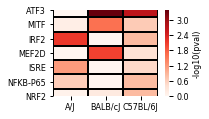

In [12]:
# set plot size
fig, ax = plt.subplots(figsize=(60/mm_conv, 40/mm_conv))

# convert to a log2 frame
tmp_frame = np.log10(np.e**(tmp_frame))

cm = sns.heatmap(
    -tmp_frame,
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    # annot=True,
    cbar_kws={'label': '-log10(pval)'})
    #square=True)

plt.savefig('./atac_known_motif_heatmap/homer_enrichedmotifs_custommotifs_intersection_enhancers.pdf',
            bbox_inches='tight')

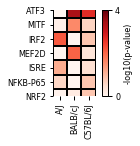

In [23]:
# set plot size
fig, ax = plt.subplots(figsize=(60/mm_conv, 40/mm_conv))

cm = sns.heatmap(
    -tmp_frame,s
    cmap='Reds',
    linewidths=1,
    linecolor='black',
    cbar=False,
    vmin=0,
    vmax=4,
    # annot=True,
    #cbar_kws={'label': '-log10(pval)'},
    square=True)

# colorbar
cmap = matplotlib.cm.Reds
norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap=cmap),
                  ax=ax,
                  orientation='vertical',
                  ticks=[0,4],
                  label='-log10(p-value)',
                  use_gridspec=True,
                  shrink=1,
                  pad=0.05,
                  fraction=0.05,
                  aspect=15
                  )

plt.savefig('./atac_known_motif_heatmap/homer_enrichedmotifs_custommotifs_intersection_enhancers_square.pdf',
            bbox_inches='tight')